In [102]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(7)
import os

In [96]:
TIMESERIES = "data/timeseries.csv"
SUBMISSIONS = "submissions"

In [62]:
df = pd.read_csv(TIMESERIES, parse_dates=['Date', 'DateIdx'])

In [63]:
len(df)

35040

In [64]:
sum(df.DateIdx == df.Date)

35040

In [65]:
cols = df.columns

In [66]:
cols

Index([u'DateIdx', u'Date', u'VAR', u'dewpti', u'hum', u'pressurei', u'rain',
       u'tempi', u'thunder', u'Day', u'Holiday', u'PCA_1'],
      dtype='object')

In [67]:
df = df[cols[1:]]

In [68]:
df.head()

,Date,VAR,dewpti,hum,pressurei,rain,tempi,thunder,Day,Holiday,PCA_1
0,2016-05-01 00:00:00,24.25751,62.30,82.000000,29.960000,0.0,67.500000,0.0,1,0,-15.419709
1,2016-05-01 00:15:00,25.38191,49.85,84.458356,29.832557,0.0,67.257999,0.0,1,0,198.166945
2,2016-05-01 00:30:00,25.10542,62.60,88.000000,29.950000,0.0,66.200000,0.0,1,0,104.502454
3,2016-05-01 00:45:00,24.22065,62.45,85.750000,29.950000,0.0,66.400000,0.0,1,0,119.514737
4,2016-05-01 01:00:00,24.18378,62.30,83.500000,29.950000,0.0,66.600000,0.0,1,0,134.532242


In [69]:
df.Date#[~df.VAR.isna()]

0       2016-05-01 00:00:00
1       2016-05-01 00:15:00
2       2016-05-01 00:30:00
3       2016-05-01 00:45:00
4       2016-05-01 01:00:00
5       2016-05-01 01:15:00
6       2016-05-01 01:30:00
7       2016-05-01 01:45:00
8       2016-05-01 02:00:00
9       2016-05-01 02:15:00
10      2016-05-01 02:30:00
11      2016-05-01 02:45:00
12      2016-05-01 03:00:00
13      2016-05-01 03:15:00
14      2016-05-01 03:30:00
15      2016-05-01 03:45:00
16      2016-05-01 04:00:00
17      2016-05-01 04:15:00
18      2016-05-01 04:30:00
19      2016-05-01 04:45:00
20      2016-05-01 05:00:00
21      2016-05-01 05:15:00
22      2016-05-01 05:30:00
23      2016-05-01 05:45:00
24      2016-05-01 06:00:00
25      2016-05-01 06:15:00
26      2016-05-01 06:30:00
27      2016-05-01 06:45:00
28      2016-05-01 07:00:00
29      2016-05-01 07:15:00
                ...        
35010   2017-04-30 16:30:00
35011   2017-04-30 16:45:00
35012   2017-04-30 17:00:00
35013   2017-04-30 17:15:00
35014   2017-04-30 1

### Dodanie kolumn z czasem

In [70]:
df['month'] = pd.to_datetime(df['Date']).apply(lambda x: x.month)
df['day'] = pd.to_datetime(df['Date']).apply(lambda x: x.day)
df['hour'] = pd.to_datetime(df['Date']).apply(lambda x: x.hour)
df['minute'] = pd.to_datetime(df['Date']).apply(lambda x: x.minute)

In [71]:
sum(df.VAR.isna())

672

In [72]:
train_df = df[~df.VAR.isna()]

In [73]:
test_df = df[df.VAR.isna()]

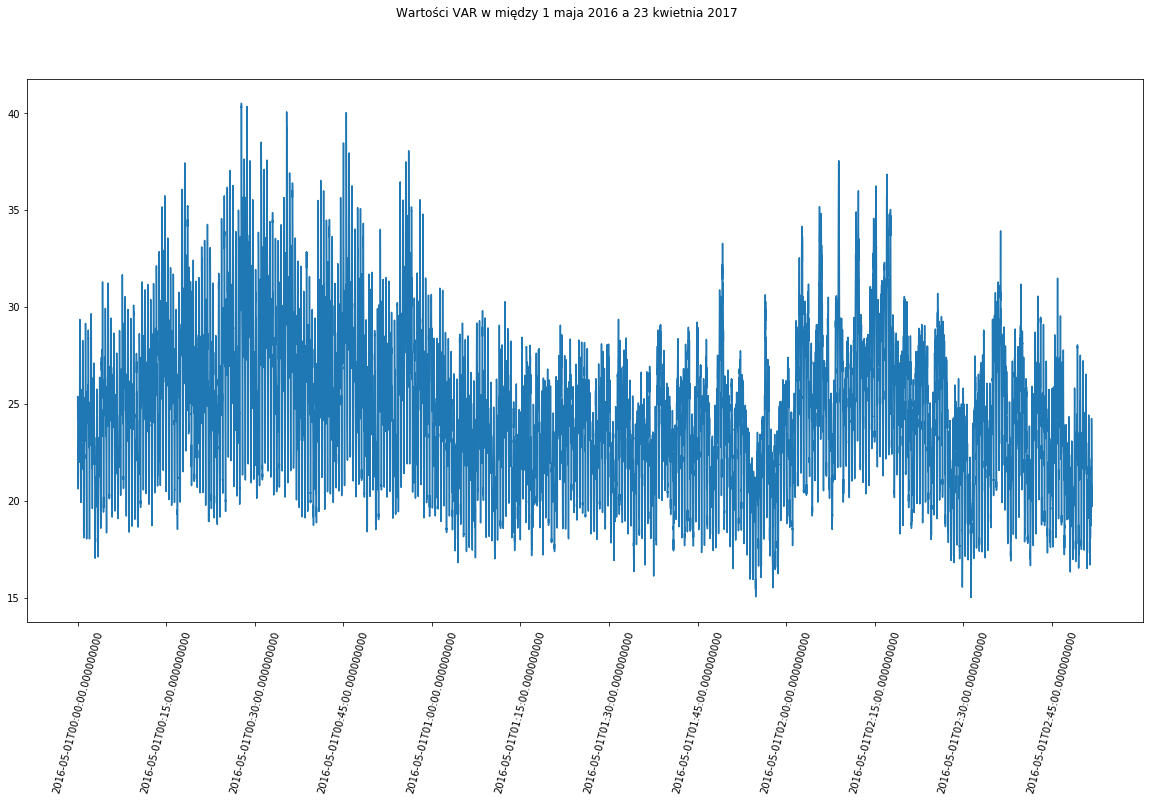

In [74]:
plt.figure(figsize=(20,10))
plt.plot(train_df.VAR)
plt.suptitle(u"Wartości VAR w między 1 maja 2016 a 23 kwietnia 2017")
plt.xticks(np.arange(0, len(train_df.VAR), 3000), train_df.Date.values[:3000], rotation=75)
plt.savefig("output/var_values.png")
plt.show()

### Podział datasetu

In [75]:
idx = range(len(train_df))
len(idx)

34368

In [76]:
from sklearn.utils import resample

In [77]:
dev_last_idx = int(0.8 * len(idx))
resampled_idx = resample(idx)

In [78]:
dev_idx = resampled_idx[:dev_last_idx]
dev_test_idx = resampled_idx[dev_last_idx:]

### Zapisanie datasetu

In [79]:
import json

In [80]:
split = {"train": dev_idx,
        "test": dev_test_idx}

In [81]:
with open("data/split_v1", "wb") as f:
    json.dump(split, f)

### Ground truth

In [82]:
columns = df.columns
columns

Index([u'Date', u'VAR', u'dewpti', u'hum', u'pressurei', u'rain', u'tempi',
       u'thunder', u'Day', u'Holiday', u'PCA_1', u'month', u'day', u'hour',
       u'minute'],
      dtype='object')

In [83]:
FEATURES = columns.drop(["Date","VAR"])
GROUND_TRUTH = ["VAR"]

### Baseline - XGBoost

In [84]:
import xgboost as xgb

In [85]:
model = xgb.XGBRegressor()

In [86]:
X_train = df.iloc[dev_idx][FEATURES].values
y_train = df.iloc[dev_idx][GROUND_TRUTH].values.ravel()

In [87]:
X_test = df.iloc[dev_test_idx][FEATURES].values
y_test = df.iloc[dev_test_idx][GROUND_TRUTH].values.ravel()

In [88]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [89]:
y_pred = model.predict(X_test)

### RMSE

In [90]:
rmse = np.sqrt(((y_test - y_pred)**2).mean())
rmse

1.418583689485819

### MAE

In [91]:
mae = np.abs(y_test - y_pred).mean()
mae

1.092249073563631

### R<sup>2</sup>

In [92]:
y_mean = y_test.mean()
ss_residual = ((y_test - y_pred)**2).sum()
ss_total = ((y_test - y_mean)**2).sum()
R2 = 1 - (ss_residual / ss_total)
R2

0.8616066553080487

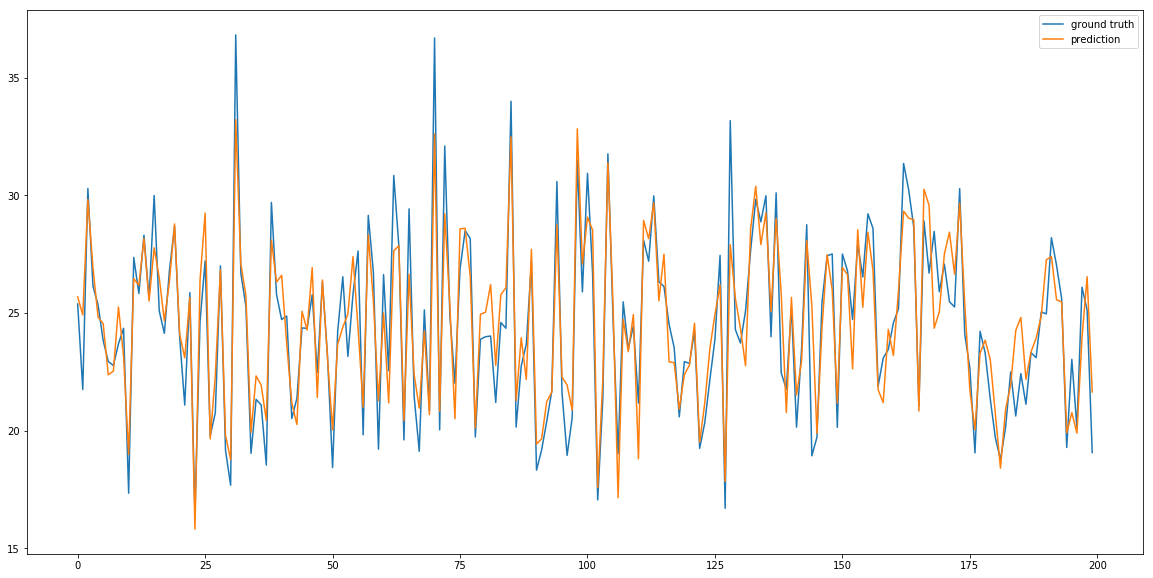

In [115]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:200], label="ground truth")
plt.plot(y_pred[:200], label="prediction")
plt.legend()
plt.savefig("output/xgb_split_v1.png",  bbox_inches='tight')

### Wynik

In [97]:
X_holdout = test_df[FEATURES].values

In [99]:
y_holdout_pred  = model.predict(X_holdout)
y_holdout_dates = test_df.Date

In [107]:
pd.DataFrame({"Date": y_holdout_dates, "VAR": y_holdout_pred}).to_csv(
    os.path.join(SUBMISSIONS, "baseline_xgb_v1.csv"), index=None)